###### Maddox Johnston, Mary Geer Kirkland, Paul Dierksheide

### This project aims to explain data trends from a popular bikeshare stand in London through the years 2015-2018. Three main questions we are interested in are: 
1. How is the amount of bike rentals affected by the current wind speed?
2. Are there more bike rentals on a weekend compared to a weekday?
3. Do holidays affect the number of bikes rented? If so, how?

### The dataset we are working with consists of hourly data from a bikeshare stand in London. The grain of the set is an hour. 

### For each hour, the dataset provides various other data points: true temperature (t1), apparent temperature (t2), humidity (hum), wind speed, season, and a general description of the weather (weather code). Additionally, we are given the binary indicators "is_weekend" (is it a weekend? 1 = yes), and "is_holiday". This dataset has 17,000 rows: hourly data across 3 years. 


### In order to explain these trends, we will use a finely tuned decision tree, and various poisson regressions. The decision tree model will show which parameters of the data set affect bike rentals. Similarly, the poisson regression will explain the percentile increase/decrease in bike rentals from an isolated variable of our interest. 

In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from itertools import chain
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import statsmodels.api as sm
from scipy import stats
from statsmodels.tools import add_constant
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus
from sklearn.datasets import load_iris
import collections

path = 'london_merged-1.csv'    #loads data
data = pd.read_csv(path)
print(data.dtypes)   #show the columns
data.head(10)

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code      int64
is_holiday        int64
is_weekend        int64
season            int64
dtype: object


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,1/4/15 0:00,182,3.0,2.0,93.0,6.0,3,0,1,3
1,1/4/15 1:00,138,3.0,2.5,93.0,5.0,1,0,1,3
2,1/4/15 2:00,134,2.5,2.5,96.5,0.0,1,0,1,3
3,1/4/15 3:00,72,2.0,2.0,100.0,0.0,1,0,1,3
4,1/4/15 4:00,47,2.0,0.0,93.0,6.5,1,0,1,3
5,1/4/15 5:00,46,2.0,2.0,93.0,4.0,1,0,1,3
6,1/4/15 6:00,51,1.0,-1.0,100.0,7.0,4,0,1,3
7,1/4/15 7:00,75,1.0,-1.0,100.0,7.0,4,0,1,3
8,1/4/15 8:00,131,1.5,-1.0,96.5,8.0,4,0,1,3
9,1/4/15 9:00,301,2.0,-0.5,100.0,9.0,3,0,1,3


In [3]:
#feature_cols = ['is_weekend', 'is_holiday', 'wind_speed', "hum", "season"]

import datetime
data['time'] = pd.to_datetime(data["timestamp"])
#print(time) Debug code
data['weekday'] = data['time'].dt.dayofweek
data['hour'] = data['time'].dt.hour
data['dayofyear'] = data['time'].dt.dayofyear
data['year'] = data['time'].dt.year


feature_cols = ["t2","t1","wind_speed","dayofyear","hour"]

X = data[feature_cols] # Features
y = data.cnt # Target variable



In [4]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [5]:
# Create Decision Tree Regressor object
clf = DecisionTreeRegressor(max_leaf_nodes=100, random_state=0)

# Train Decision Tree Regressor
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)



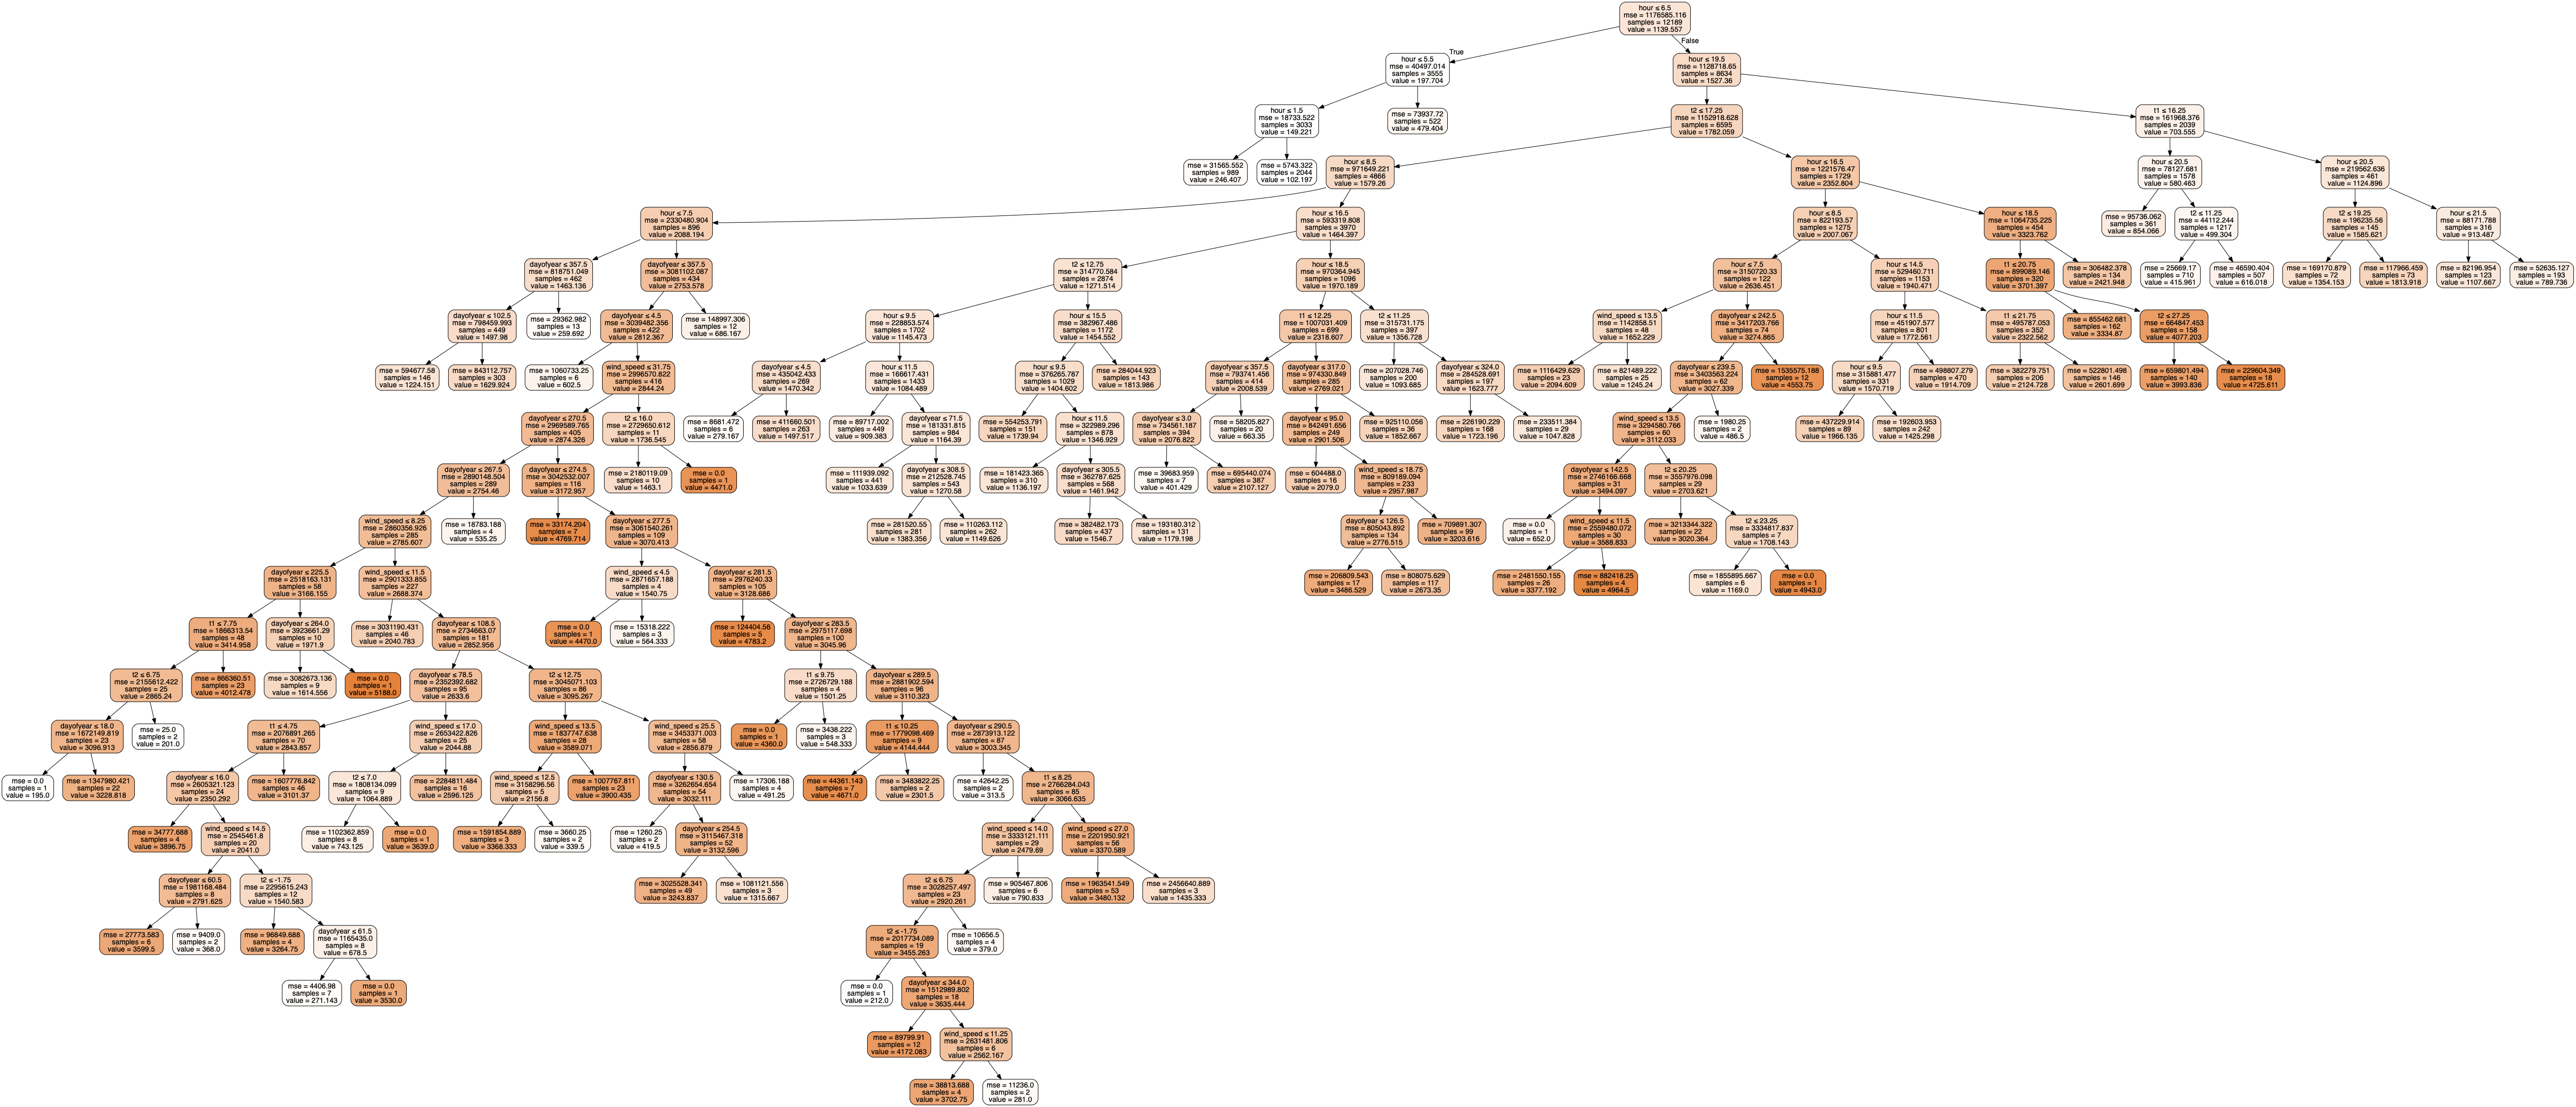

In [10]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names = feature_cols, 
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph
Image(graph.create_png())
graph.write_png("Dtree.png")   #Writes the Decision Tree to an image
from IPython.display import Image
Image("Dtree.png")


In [11]:
print("Completeness:",metrics.completeness_score(y_test, y_pred)) #Shows the accuracy of our Decision Tree

Completeness: 0.8066349711349481


In [106]:
y_pred.shape


(5225,)

In [107]:
y_pred[0:10]

array([1629.92409241,  789.7357513 , 1033.63945578, 1546.70022883,
        909.3830735 , 2107.12661499,  854.06648199, 1425.29752066,
       1914.70851064, 1546.70022883])

In [108]:
from statsmodels.discrete.discrete_model import Poisson
model =Poisson(endog=data.cnt, exog=add_constant(data.wind_speed)) #poisson on wind_speed
results = model.fit()
print(results.summary())
model =Poisson(endog=data.cnt, exog=add_constant(data.is_weekend)) #poisson on is weekend
results = model.fit()
print(results.summary())
model =Poisson(endog=data.cnt, exog=add_constant(data.is_holiday)) #poisson on holiday
results = model.fit()
print(results.summary())
model =Poisson(endog=data.cnt, exog=add_constant(data.t2)) #poisson on t2
results = model.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 479.294087
         Iterations 4
                          Poisson Regression Results                          
Dep. Variable:                    cnt   No. Observations:                17414
Model:                        Poisson   Df Residuals:                    17412
Method:                           MLE   Df Model:                            1
Date:                Sun, 01 Dec 2019   Pseudo R-squ.:                 0.01399
Time:                        12:06:47   Log-Likelihood:            -8.3464e+06
converged:                       True   LL-Null:                   -8.4648e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8210      0.001   1.33e+04      0.000       6.820       6.822
wind_speed     0.0135   2.7

In [109]:

is_holidaycoef = 1 - np.exp(-0.4031)
is_wkndcoef = 1 - np.exp(-0.2129)
t2coef = np.exp(.054) - 1
windcoef = np.exp(.0135) - 1
print('is_holiday coefficent exponetiated: {} '.format(np.exp(-.4031)))
print('is_weekend coefficent exponetiated: {} '.format(np.exp(-.2129)))
print('t2 coefficent exponetiated: {} '.format(np.exp(.054)))
print('wind_speed coefficent exponetiated: {} '.format(np.exp(.0135)))

is_holiday coefficent exponetiated: 0.6682452714550771 
is_weekend coefficent exponetiated: 0.8082369568711254 
t2 coefficent exponetiated: 1.05548460215508 
wind_speed coefficent exponetiated: 1.0135915364502062 


### We ran four poisson regressions on four different isolated variables: is_holiday (is it a holiday? 1 = yes), is_weekend (is it a weekend? 1 = yes), t2 (apparent temperature) and wind_speed (wind speed in km/h).

### The results were quite interesting. 33% less bikes were rented on holidays, 19% less bikes were rented on weekends. Correspondingly, the wind speed was only slightly influential on the number of bikes rented; a 1 km/h increase in wind speed caused 1.3% more bikes to be rented, although this regression had an extremely low R^2 value, indicating it was not a good indicator.

### A poisson regression ran on apparent temperature yielded clear effects. For every degree increase in apparent temperature, 5.5% more bikes were rented (Although this may seem negligible, think of it as a 20 degree warmer day would rent double the bikes). This makes sense, since our bike stand is a cool climate, so warmer days would make it nicer to spend time doing outdoor activities.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


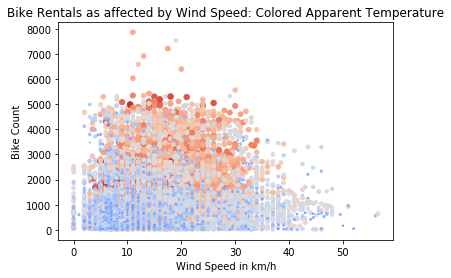

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline

x = data.wind_speed
x_lab = 'Wind Speed in km/h'
y_lab = 'Bike Count'
y = data.cnt
s = data.t2 ## scale 
c = data.t2  ## color

## Plotting script
plt.scatter(x, y, s, c, cmap ='coolwarm')
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.title('Bike Rentals as affected by Wind Speed: Colored Apparent Temperature')
plt.show()

#### This plot (above) shows how wind speed and temperature affected the number of bikes sold. The larger and "warmer" dots correspond to warmer days, while the small blue dots are colder, windier days. Notice how most days where many bikes were rented were warm, and often not extremely windy.

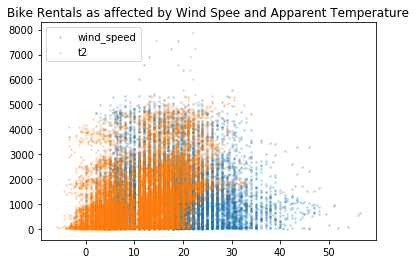

In [111]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(data.wind_speed, data.cnt,s=3,alpha=.2)
plt.scatter(data.t2, data.cnt,s=3,alpha=.2)
plt.title('Bike Rentals as affected by Wind Spee and Apparent Temperature')
plt.legend(['wind_speed', 't2'], loc='upper left')

plt.show()

#### In this plot (above), the orange dots correspond to temperature readings, and the blue dots wind speed. We note how the temperature has a clear net positive correlation on number of bikes rented.

### As noted above, results from our decision tree and poisson regression indicate that "t2" (apparent temperature: a combination of temperature and humidity) is the single largest factor that affects the number of bikes rented. Also, much less bikes were rented on holidays, and a good bit less on weekends.  We also learned that wind speed was not a good indicator of bikes rentals. 

### If I were the business owner of a bikeshare rental in London, I would perhaps allocate less resources toward bike rentals on holidays, since they, have on average, less bike rentals taking pless. Similarly, if i was expecting a week of warm, pleasant temperatures, I would make sure I had enough bikes to rent out, and that they were in good condition, since this weather seems to make people more inclided to cycle. Conversley, if I knew a windy day was expected, I would not let this affect my plans, since it does not seem to have a real effect on bike rentals. 

In [112]:
!export PATH=/Library/TeX/texbin:$PATH